# **Modelos Benchmarks**

In [1]:
# Librerias Importadas
from sklearn.model_selection import learning_curve
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from sklearn.svm import SVR



Se importa la base de datos y definimos las variables predictoras y la variable respuesta. Luego, dividimos los datos para formar el conjunto de entrenamiento y el de prueba.

In [2]:
# Cargar datos
df = pd.read_csv(r"C:\Users\TAWTOCA\OneDrive - Universidad del Norte\Documentos\Visual Folders\Visual Files\Rentabilidad_filtrado.csv")

# Definir variables predictoras y respuesta
X = df[["APORTES_RECIBIDOS", "PRECIERRE_FONDO_DIA_T", "TIPO_PARTICIPACION", "NUMERO_INVERSIONISTAS", "TIPO_ENTIDAD"]]
y = df["RETIROS_REDENCIONES"]

# Primera división: Train + Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Segunda división: Train + Validation (por ejemplo, 20% del 80% original → 0.2/0.8 = 0.25)
X_temp, X_val, y_temp, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [3]:


# Diccionario de modelos
modelos = {
    'lineal': LinearRegression(),
    'ridge': Ridge(alpha=1.0),
    'lasso': Lasso(alpha=0.1),
    'knn': KNeighborsRegressor(n_neighbors=5),
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'xgboost': XGBRegressor(n_estimators=100, random_state=42),
    'svr': SVR()
}

# Diccionario con espacios de hiperparámetros
param_distributions = {
    'lineal': {},  # sin hiperparámetros
    'ridge': {'model__alpha': uniform(0.01, 10)},
    'lasso': {'model__alpha': uniform(0.001, 1)},
    'knn': {
        'model__n_neighbors': randint(5, 30),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    'random_forest': {
        'model__n_estimators': randint(50, 150),
        'model__max_depth': [10, 20, 30, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'xgboost': {
        'model__n_estimators': randint(50, 150),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': randint(3, 10),
        'model__subsample': uniform(0.7, 0.3),
        'model__colsample_bytree': uniform(0.7, 0.3),
        'model__gamma': uniform(0, 5),
        'model__min_child_weight': randint(1, 10)
    },
    'svr': {
        'model__kernel': ['linear', 'rbf'],
        'model__C': uniform(0.1, 10),
        'model__epsilon': uniform(0.01, 1),
        'model__gamma': ['scale', 'auto']
    }
}


In [4]:
def entrenar_modelo(nombre_modelo, modelos, param_distributions, X_train, y_train, X_test, y_test, n_iter=10, cv=3):
    modelo = modelos[nombre_modelo]
    params = param_distributions.get(nombre_modelo, {})

    # Incluir modelos que requieren escalado
    modelos_con_escalado = ['lineal', 'ridge', 'lasso', 'knn', 'svr']
    pasos = []

    if nombre_modelo in modelos_con_escalado:
        pasos.append(('scaler', StandardScaler()))
    pasos.append(('model', modelo))

    pipeline = Pipeline(pasos)

    # Si hay hiperparámetros definidos, aplica búsqueda
    if params:
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=params,
            n_iter=n_iter,
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
    else:
        search = pipeline

    st = time.time()
    search.fit(X_train, y_train)
    et = time.time()

    y_pred = search.predict(X_test)

    print(f"\nModelo: {nombre_modelo}")
    print(f"  Tiempo de entrenamiento: {et - st:.2f} segundos")
    print(f"  Train R²: {search.score(X_train, y_train):.2f}")
    print(f"  Test R²:  {r2_score(y_test, y_pred):.2f}")

    if hasattr(search, 'best_params_'):
        print("  Mejores parámetros:", search.best_params_)

    return search

In [5]:
def graficar_curva_aprendizaje(pipeline, X, y, nombre_modelo='modelo', scoring='r2', cv=5):
    """
    Dibuja la curva de aprendizaje del modelo.

    Parámetros:
    - pipeline: pipeline con preprocesamiento y modelo ya definido.
    - X, y: dataset completo.
    - nombre_modelo: nombre del modelo para el título del gráfico.
    - scoring: métrica a usar ('r2', 'neg_mean_squared_error', etc.)
    - cv: número de particiones para validación cruzada.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=pipeline,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean,  label='Entrenamiento', color='blue')
    plt.plot(train_sizes, val_scores_mean, label='Validación', color='orange')

    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel(scoring.upper())
    plt.title(f"Curva de Aprendizaje - {nombre_modelo}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:

def graficar_diagnostico(modelo_entrenado, X, y_real, nombre_conjunto="Test"):
    """
    Dibuja:
    - Valor real vs. predicción
    - ACF de los residuos con Ljung-Box
    - Histograma de residuos

    Parámetros:
    - modelo_entrenado: modelo o pipeline entrenado
    - X: features
    - y_real: variable objetivo real
    - nombre_conjunto: etiqueta para mostrar en el título
    """
    y_pred = modelo_entrenado.predict(X)
    residuales = y_real - y_pred

    # Ljung-Box
    lb_pvalue = acorr_ljungbox(residuales, lags=[10], return_df=True)['lb_pvalue'].values[0]

    # Gráficos
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Real vs. Predicho
    sns.scatterplot(x=y_real, y=y_pred, ax=axes[0], alpha=0.5)
    axes[0].plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
    axes[0].set_title(f'{nombre_conjunto}: Real vs. Predicho')
    axes[0].set_xlabel('Real')
    axes[0].set_ylabel('Predicción')
    axes[0].grid(True)

    # 2. ACF de los residuos
    plot_acf(residuales, ax=axes[1], lags=40, alpha=0.05)
    axes[1].set_title(f'ACF de residuos\nLjung-Box p-value = {lb_pvalue:.4f}')

    # 3. Histograma de residuos
    sns.histplot(residuales, kde=True, ax=axes[2], bins=30, color='gray')
    axes[2].set_title('Histograma de residuos')
    axes[2].set_xlabel('Error')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


## **Modelos**

In [7]:
knn = entrenar_modelo('knn', modelos, param_distributions, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Modelo: knn
  Tiempo de entrenamiento: 181.75 segundos
  Train R²: 0.72
  Test R²:  0.76
  Mejores parámetros: {'model__n_neighbors': 23, 'model__p': 1, 'model__weights': 'uniform'}


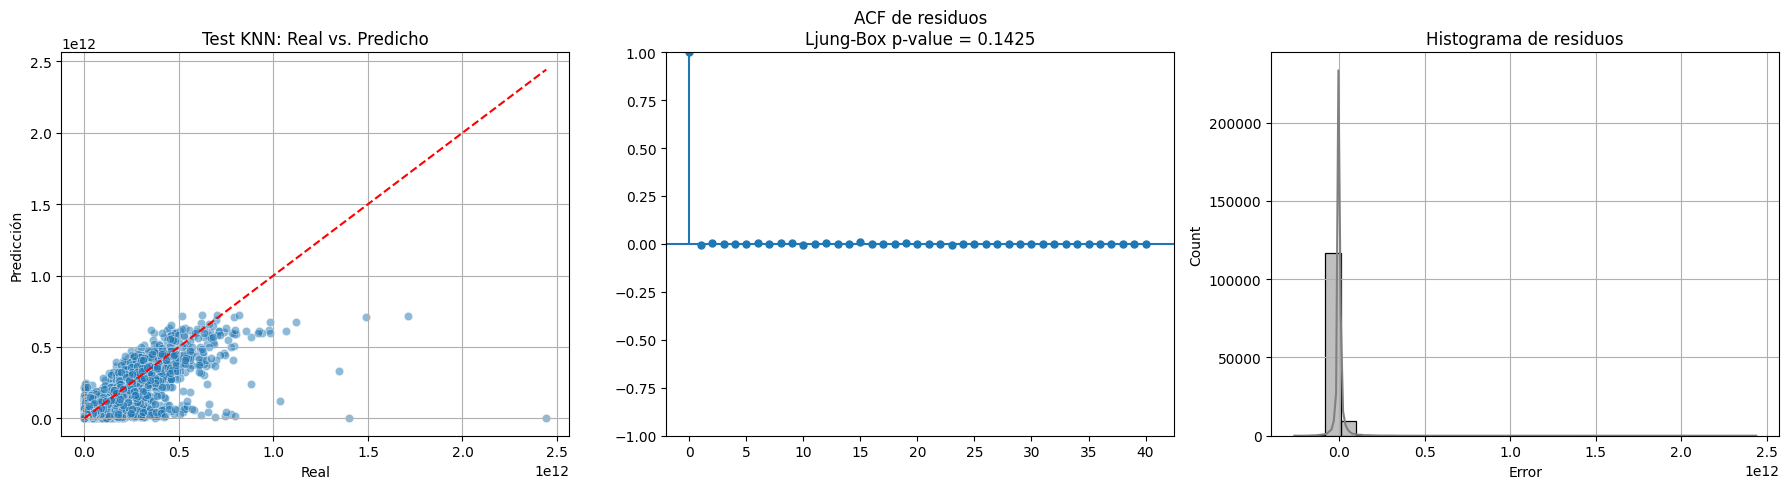

In [8]:
graficar_diagnostico(knn, X_test, y_test, nombre_conjunto="Test KNN")